This notebook compares different implementations of the rescoring algorithm for finding successively better scores after an initial scoring calculation.

First we import the packages required for the tests

In [1]:
import numpy as np
import numba
import perfplot

Function to find the pattern with the best score

In [2]:
# Generate score for each patterns
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def first_score_patterns(patterns, skip_patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]

    scores = np.zeros(npatterns, np.int32)
    
    for p in numba.prange(0, npatterns):
        if not skip_patterns[p]:
            score: int = 0
            bins = np.zeros(4, np.int32)
            for i in range(0, ncols):
                bins[patterns[p, i]] += 1
            score = bins[0] * bins[1] + (bins[0] + bins[1]) * bins[2]
            scores[p] = score

            if score == 0:
                skip_patterns[p] = 1
                
    return scores

Function to calculate the best possible score that could be achieved using all of the patterns

In [3]:
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def calculate_best_possible_score(patterns):

    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
    
    score: int = 0
    # Rearrange the loopps so the main loop ends early when a cell is filled
    for i in numba.prange(0, ncols):
        for j in range(0, i):
            for p in range(0, npatterns): # Striding here, so cache misses more likely. Transposing the matrix first may be faster.
                ival: int = patterns[p, i]
                jval: int = patterns[p, j]
                if ival != -1 and jval != -1 and ival != jval:
                    score += 1
                    break # stop early if cell contains a one

    return score

Utility functions used in rescoring

In [4]:
@numba.jit(nopython=True, fastmath=True, nogil=True, parallel=True, cache=True)
def _create_matrix(pattern, matrix):
    """Create the stencil matrix for this pattern, based on the
       current value of the combined stencil matrix (i.e. only
       cover up holes that are not already covered
    """
    n = len(pattern)

    m = np.zeros((n, n), np.int8)

    for i in numba.prange(0, n):
        ival = pattern[i]

        if ival != -1:
            for j in range(i+1, n):
                jval = pattern[j]

                # If this cell in the matrix is currently set to zero,
                # i.e. this pair of varieties (i and j) are unresolved,
                # and their genotypes are valid and different, then we can
                # set this cell in the test matrix to 1 (= resolved) -
                # otherwise it remains set to zero.
                if jval != -1 and ival != jval and matrix[i, j] == 0:
                    m[i, j] = 1

    return m

@numba.jit(nopython=True, cache=True)
def _unmatched_element_indices(pattern, expected_size):
    """Calculate the co-ordinates of the elements with value
       zero in the matrix corresponding to the passed in pattern.
       Returns
       =======
            indices : N x 2 numpy array containing row/column of each zero
    """
    indices = np.empty((expected_size, 2), dtype=np.int64)
    nele: int = pattern.size
    idx: int = 0 # shared across iterations, so can't parallelise the loops
    for i in range(0, nele):
        ival: int = pattern[i]
        for j in range(0, i):
            jval: int = pattern[j]
            if ival == -1 or jval == -1 or ival == jval:
                indices[idx, 0] = i
                indices[idx, 1] = j
                idx += 1

    if idx != expected_size:
        print(f'{idx} does not match expected number of elements ({expected_size})')

    return indices

@numba.jit(nopython=True, cache=True)
def _remove_matched_indices(data, indices, num_fewer):
    """Removes indices from the input array corresponding to
       ones in the matrix generated from the data array
       Returns
       =======
            new_indices : N x 2 numpy array containing the new indices
    """
    num_old: int = indices.shape[0]
    new_size: int = num_old - num_fewer
    nrows: int = data.shape[0]
    new_indices = np.empty((new_size, 2), dtype=np.int64)
    new_idx: int = 0 # shared accross iterations, so can't parallelise the loop
    for old_idx in range(0, num_old):
        i: int = indices[old_idx, 0]
        j: int = indices[old_idx, 1]
        ival: int = data[i]
        jval: int = data[j]
        if ival == -1 or jval == -1 or ival == jval:
            new_indices[new_idx] = [i, j]
            new_idx += 1

    if new_idx != new_size:
        print(f'{new_idx} does not match expected number of new elements ({new_size})')

    return new_indices

Original rescoring function

In [5]:
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def _rescore_patterns(patterns, matrix, skip_patterns, scores, sorted_idxs):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
    nthreads: int = numba.config.NUMBA_NUM_THREADS

    for thread_id in numba.prange(0, nthreads):
        my_best_score: int = 0

        for chunk in range(0, npatterns, nthreads):
            idx: int = chunk + thread_id

            if idx >= npatterns:
                break

            p: int = sorted_idxs[idx]

            if skip_patterns[p]:
                continue

            current_score: int = scores[p]

            if current_score < my_best_score:
                # there are no more patterns with a better score
                break

            # this pattern could be the best scoring pattern...
            score: int = 0

            for i in range(0, ncols):
                ival: int = patterns[p, i]

                if ival != -1:
                    for j in range(i+1, ncols):
                        jval: int = patterns[p, j]
                        score += (jval != -1 and ival != jval and matrix[i, j] == 0)

            scores[p] = score

            if score == 0:
                skip_patterns[p] = 1

            if score > my_best_score:
                my_best_score = score

    return np.argsort(scores)[::-1]

def rescore_original(patterns, scores, best_possible_score, skip_patterns):
    scores = np.array(scores) # function modifies this array, so make a copy
    skip_patterns = np.array(skip_patterns) # function modifies this array, so make a copy
    
    sorted_idxs = np.argsort(scores)[::-1]
    best_pattern = sorted_idxs[0]
    best_score: int = scores[best_pattern]
    best_patterns = [(best_pattern, best_score)]
    
    cumulative_score: int = best_score
    current_score: int = best_score

    # patterns which have been used are given a score of zero
    scores[best_pattern] = 0
    skip_patterns[best_pattern] = 1
    
    ncols: int = patterns.shape[1]

    # create the matrix showing which varieties can be distinguished
    matrix = np.zeros((ncols, ncols), np.int8)
    matrix = _create_matrix(patterns[best_pattern], matrix)

    while current_score > 0:
        sorted_idxs = _rescore_patterns(patterns, matrix, skip_patterns, scores, sorted_idxs)

        best_pattern = sorted_idxs[0]
        best_score = scores[best_pattern]

        if best_score > 0:
            cumulative_score += best_score
            best_patterns.append((best_pattern, cumulative_score))

            scores[best_pattern] = 0
            skip_patterns[best_pattern] = 1

            matrix += _create_matrix(patterns[best_pattern], matrix)

            if cumulative_score == best_possible_score:
                break

        current_score: int = best_score
        
    return cumulative_score

Keep track of unused cells in the form of a sparse matrix, reducing the number of comparisons required for each iteration

In [6]:
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def _rescore_patterns_sparse(patterns, indices, skip_patterns, scores, sorted_idxs):
    nidx: int = indices.shape[0]
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
    nthreads: int = numba.config.NUMBA_NUM_THREADS

    for thread_id in numba.prange(0, nthreads):
        my_best_score: int = 0

        for chunk in range(0, npatterns, nthreads):
            idx: int = chunk + thread_id

            if idx >= npatterns:
                break

            p: int = sorted_idxs[idx]

            if skip_patterns[p]:
                continue

            current_score: int = scores[p]

            if current_score < my_best_score:
                # there are no more patterns with a better score
                break

            # this pattern could be the best scoring pattern...
            score: int = 0

            for idx in range(0, nidx):
                i: int = indices[idx, 0]
                j: int  = indices[idx, 1]
                ival: int = patterns[p, i]
                jval: int = patterns[p, j]
                if ival != -1 and jval != -1 and ival != jval:
                    score += 1

            scores[p] = score

            if score == 0:
                skip_patterns[p] = 1

            if score > my_best_score:
                my_best_score = score

    return np.argsort(scores)[::-1]

def rescore_sparse(patterns, scores, best_possible_score, skip_patterns):
    scores = np.array(scores) # function modifies this array, so make a copy
    skip_patterns = np.array(skip_patterns) # function modifies this array, so make a copy
    
    sorted_idxs = np.argsort(scores)[::-1]
    best_pattern = sorted_idxs[0]
    best_score: int = scores[best_pattern]
    best_patterns = [(best_pattern, best_score)]
    
    cumulative_score: int = best_score
    current_score: int = best_score

    # patterns which have been used are given a score of zero
    scores[best_pattern] = 0
    skip_patterns[best_pattern] = 1
    
    ncols: int = len(patterns[0])
    perfect_score: int = int((ncols * (ncols-1)) / 2)

    # number of elements that can still distinguish varieties
    nremain = perfect_score - best_score
    
    # create a list indicies representing a sparse matrix containing the elements
    # can be still be used to distinguish varieties
    remaining_indices = _unmatched_element_indices(patterns[best_pattern], nremain)

    while current_score > 0:
        sorted_idxs = _rescore_patterns_sparse(patterns, remaining_indices, skip_patterns, scores, sorted_idxs)

        best_pattern = sorted_idxs[0]
        best_score = scores[best_pattern]

        if best_score > 0:
            cumulative_score += best_score
            best_patterns.append((best_pattern, cumulative_score))

            scores[best_pattern] = 0
            skip_patterns[best_pattern] = 1

            remaining_indices = _remove_matched_indices(patterns[best_pattern], remaining_indices, best_score)
            
            if cumulative_score == best_possible_score:
                break

        current_score: int = best_score
        
    return cumulative_score

Avoid resorting the scores each time they are updated, not that if there are ties this can return a different pattern order to the versions above

In [7]:
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def _rescore_patterns_nosort(patterns, indices, skip_patterns, scores):
    nidx: int = indices.shape[0]
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]

    best_score: int = 0 # thread local variable
    
    for p in numba.prange(0, npatterns):
        if skip_patterns[p]:
            continue
        if scores[p] < best_score:
            continue

        # this pattern could be the best scoring pattern...
        score: int = 0
            
        for idx in range(0, nidx):
            i: int = indices[idx, 0]
            j: int  = indices[idx, 1]
            ival: int = patterns[p, i]
            jval: int = patterns[p, j]
            if ival != -1 and jval != -1 and ival != jval:
                score += 1

        scores[p] = score

        if score == 0:
            skip_patterns[p] = 1
        if score > best_score:
            best_score = score
            
def rescore_nosort(patterns, scores, best_possible_score, skip_patterns):
    scores = np.array(scores) # function modifies this array, so make a copy
    skip_patterns = np.array(skip_patterns) # function modifies this array, so make a copy
    
    best_pattern = np.argmax(scores)
    best_score: int = scores[best_pattern]
    best_patterns = [(best_pattern, best_score)]
    
    cumulative_score: int = best_score
    current_score: int = best_score

    # patterns which have been used are given a score of zero
    scores[best_pattern] = 0
    skip_patterns[best_pattern] = 1
    
    ncols: int = len(patterns[0])
    perfect_score: int = int((ncols * (ncols-1)) / 2)

    # number of elements that can still distinguish varieties
    nremain = perfect_score - best_score
    
    # create a list indicies representing a sparse matrix containing the elements
    # can be still be used to distinguish varieties
    remaining_indices = _unmatched_element_indices(patterns[best_pattern], nremain)

    while current_score > 0:
        _rescore_patterns_nosort(patterns, remaining_indices, skip_patterns, scores)

        best_pattern = np.argmax(scores)
        best_score = scores[best_pattern]

        if best_score > 0:
            cumulative_score += best_score
            best_patterns.append((best_pattern, cumulative_score))

            scores[best_pattern] = 0
            skip_patterns[best_pattern] = 1

            remaining_indices = _remove_matched_indices(patterns[best_pattern], remaining_indices, best_score)
            
            if cumulative_score == best_possible_score:
                break

        current_score: int = best_score
        
    return cumulative_score

As we already know the index of the best score we can return it directly instead of having to search again later

In [8]:
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def _rescore_patterns_nosort_idx(patterns, indices, skip_patterns, scores):
    nidx: int = indices.shape[0]
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]   
    nthreads: int = numba.config.NUMBA_NUM_THREADS
    
    best_idx = np.zeros(nthreads, dtype=np.int64)
    best_score: int = 0 # thread local variable

    for thread_id in numba.prange(0, nthreads):
        my_best_score: int = 0

        for chunk in range(0, npatterns, nthreads):
            p: int = chunk + thread_id
            if p >= npatterns:
                break

            if skip_patterns[p]:
                continue
            if scores[p] < best_score:
                continue

            # this pattern could be the best scoring pattern...
            score: int = 0
            
            for idx in range(0, nidx):
                i: int = indices[idx, 0]
                j: int  = indices[idx, 1]
                ival: int = patterns[p, i]
                jval: int = patterns[p, j]
                if ival != -1 and jval != -1 and ival != jval:
                    score += 1

            scores[p] = score

            if score == 0:
                skip_patterns[p] = 1
            if score > best_score:
                best_score = score
                best_idx[thread_id] = p

    idx:int = best_idx[0]
    for thread_id in range(1, nthreads):
        if scores[best_idx[thread_id]] > scores[idx]:
            idx = best_idx[thread_id]
    return idx

def rescore_nosort_idx(patterns, scores, best_possible_score, skip_patterns):
    scores = np.array(scores) # function modifies this array, so make a copy
    skip_patterns = np.array(skip_patterns) # function modifies this array, so make a copy
    
    best_pattern = np.argmax(scores)
    best_score: int = scores[best_pattern]
    best_patterns = [(best_pattern, best_score)]
    
    cumulative_score: int = best_score
    current_score: int = best_score

    # patterns which have been used are given a score of zero
    scores[best_pattern] = 0
    skip_patterns[best_pattern] = 1
    
    ncols: int = len(patterns[0])
    perfect_score: int = int((ncols * (ncols-1)) / 2)

    # number of elements that can still distinguish varieties
    nremain = perfect_score - best_score
    
    # create a list indicies representing a sparse matrix containing the elements
    # can be still be used to distinguish varieties
    remaining_indices = _unmatched_element_indices(patterns[best_pattern], nremain)

    while current_score > 0:
        best_pattern = _rescore_patterns_nosort_idx(patterns, remaining_indices, skip_patterns, scores)
        best_score = scores[best_pattern]

        if best_score > 0:
            cumulative_score += best_score
            best_patterns.append((best_pattern, cumulative_score))

            scores[best_pattern] = 0
            skip_patterns[best_pattern] = 1

            remaining_indices = _remove_matched_indices(patterns[best_pattern], remaining_indices, best_score)
            
            if cumulative_score == best_possible_score:
                break

        current_score: int = best_score

    return cumulative_score

Create example data containing 100 patterns, and calculate initial scores

In [9]:
# Create pattern data and initial scores
def create_input_100(n_variety):
    nrows = 100 # number of different patterns to investigate
    patterns = np.random.choice([0, 1, 2, -1], (nrows, n_variety), p = [1/4, 1/4, 1/4, 1/4])
    skip_patterns = np.zeros(patterns.shape[0], np.int8)
    
    best_possible_score: int = calculate_best_possible_score(patterns)
    
    scores = first_score_patterns(patterns, skip_patterns)
    return (patterns, scores, best_possible_score, skip_patterns)

Create example data containing 1000 patterns, and calculate initial scores

In [10]:
# Create pattern data and initial scores
def create_input_1000(n_variety):
    nrows = 1000 # number of different patterns to investigate
    patterns = np.random.choice([0, 1, 2, -1], (nrows, n_variety), p = [1/4, 1/4, 1/4, 1/4])
    skip_patterns = np.zeros(patterns.shape[0], np.int8)
    
    best_possible_score: int = calculate_best_possible_score(patterns)
    
    scores = first_score_patterns(patterns, skip_patterns)
    return (patterns, scores, best_possible_score, skip_patterns)


Create example data containing 10000 patterns, and calculate initial scores

In [11]:
# Create pattern data and initial scores
def create_input_10000(n_variety):
    nrows = 10000 # number of different patterns to investigate
    patterns = np.random.choice([0, 1, 2, -1], (nrows, n_variety), p = [1/4, 1/4, 1/4, 1/4])
    skip_patterns = np.zeros(patterns.shape[0], np.int8)
    
    best_possible_score: int = calculate_best_possible_score(patterns)
    
    scores = first_score_patterns(patterns, skip_patterns)
    return (patterns, scores, best_possible_score, skip_patterns)

Create example data containing 100000 patterns, and calculate initial scores

In [12]:
# Create pattern data and initial scores
def create_input_100000(n_variety):
    nrows = 10000 # number of different patterns to investigate
    patterns = np.random.choice([0, 1, 2, -1], (nrows, n_variety), p = [1/4, 1/4, 1/4, 1/4])
    skip_patterns = np.zeros(patterns.shape[0], np.int8)
    
    best_possible_score: int = calculate_best_possible_score(patterns)
    
    scores = first_score_patterns(patterns, skip_patterns)
    return (patterns, scores, best_possible_score, skip_patterns)

Compare recscoring of 100 different patterns for increasing numbers of variation

Output()

(8.099999999999995e-06, 2.7272275)


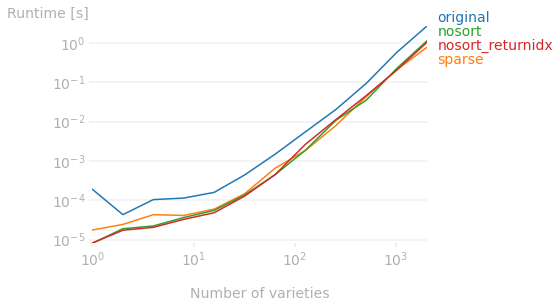

In [13]:
np.random.seed(1)
perfplot.show(
    setup=lambda n: create_input_100(n),
    kernels=[
        lambda a, b, c, d: rescore_original(a, b, c, d),
        lambda a, b, c, d: rescore_sparse(a, b, c, d),
        lambda a, b, c, d: rescore_nosort(a, b, c, d),
        lambda a, b, c, d: rescore_nosort_idx(a, b, c, d),
    ],
    labels=["original", "sparse", "nosort", "nosort_returnidx"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

Compare recscoring of 1000 different patterns for increasing numbers of variation

Output()

(1.0099999999999991e-05, 17.2762062)


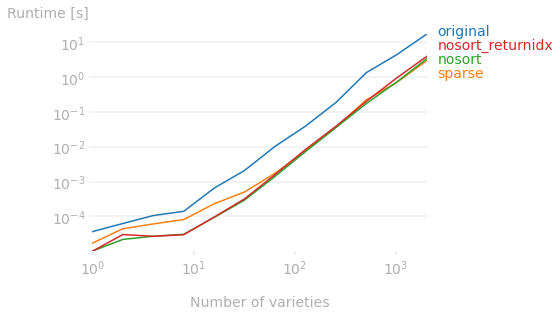

In [14]:
np.random.seed(1)
perfplot.show(
    setup=lambda n: create_input_1000(n),
    kernels=[
        lambda a, b, c, d: rescore_original(a, b, c, d),
        lambda a, b, c, d: rescore_sparse(a, b, c, d),
        lambda a, b, c, d: rescore_nosort(a, b, c, d),
        lambda a, b, c, d: rescore_nosort_idx(a, b, c, d),
    ],
    labels=["original", "sparse", "nosort", "nosort_returnidx"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

Compare recscoring of 10000 different patterns for increasing numbers of variation

Output()

(2.120000000000001e-05, 142.69301760000008)


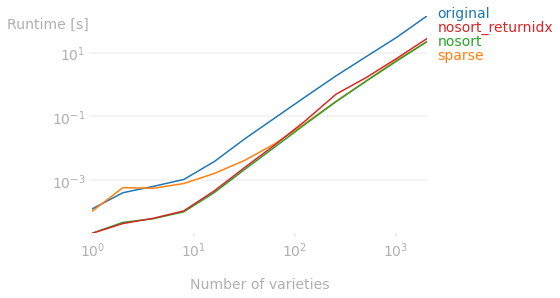

In [15]:
np.random.seed(1)
perfplot.show(
    setup=lambda n: create_input_10000(n),
    kernels=[
        lambda a, b, c, d: rescore_original(a, b, c, d),
        lambda a, b, c, d: rescore_sparse(a, b, c, d),
        lambda a, b, c, d: rescore_nosort(a, b, c, d),
        lambda a, b, c, d: rescore_nosort_idx(a, b, c, d),
    ],
    labels=["original", "sparse", "nosort", "nosort_returnidx"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

Compare recscoring of 100000 different patterns for increasing numbers of variation

Output()

(2.1300000000000016e-05, 142.15954080000006)


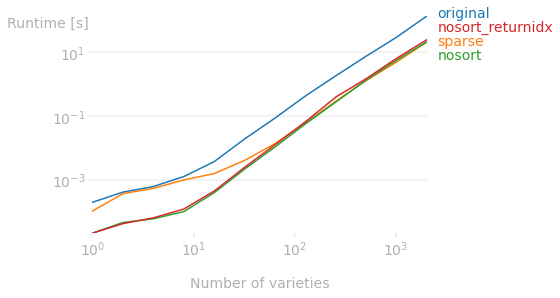

In [16]:
np.random.seed(1)
perfplot.show(
    setup=lambda n: create_input_100000(n),
    kernels=[
        lambda a, b, c, d: rescore_original(a, b, c, d),
        lambda a, b, c, d: rescore_sparse(a, b, c, d),
        lambda a, b, c, d: rescore_nosort(a, b, c, d),
        lambda a, b, c, d: rescore_nosort_idx(a, b, c, d),
    ],
    labels=["original", "sparse", "nosort", "nosort_returnidx"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)